# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from cs231n.data_utils import load_CIFAR10
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def getCIFAR10Data(numTraining = 49000, numValidation = 1000, numTest = 1000, numDev = 500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10Dir = 'cs231n/datasets/cifar-10-batches-py'
    XTrain, yTrain, XTest, yTest = load_CIFAR10(cifar10Dir)

    # subsample the data
    mask = range(numTraining, numTraining + numValidation)
    XVal = XTrain[mask]
    yVal = yTrain[mask]
    mask = range(numTraining)
    XTrain = XTrain[mask]
    yTrain = yTrain[mask]
    mask = range(numTest)
    XTest = XTest[mask]
    yTest = yTest[mask]
    mask = np.random.choice(numTraining, numDev, replace = False)
    XDev = XTrain[mask]
    yDev = yTrain[mask]

    # Preprocessing: reshape the image data into rows
    XTrain = np.reshape(XTrain, (XTrain.shape[0], -1))
    XVal = np.reshape(XVal, (XVal.shape[0], -1))
    XTest = np.reshape(XTest, (XTest.shape[0], -1))
    XDev = np.reshape(XDev, (XDev.shape[0], -1))

    # Normalize the data: subtract the mean image
    meanImage = np.mean(XTrain, axis = 0)
    XTrain -= meanImage
    XVal -= meanImage
    XTest -= meanImage
    XDev -= meanImage

    # add bias dimension and transform into columns
    XTrain = np.hstack([XTrain, np.ones((XTrain.shape[0], 1))])
    XVal = np.hstack([XVal, np.ones((XVal.shape[0], 1))])
    XTest = np.hstack([XTest, np.ones((XTest.shape[0], 1))])
    XDev = np.hstack([XDev, np.ones((XDev.shape[0], 1))])

    return XTrain, yTrain, XVal, yVal, XTest, yTest, XDev, yDev


# Invoke the above function to get our data.
XTrain, yTrain, XVal, yVal, XTest, yTest, XDev, yDev = getCIFAR10Data()
print 'Train data shape: ', XTrain.shape
print 'Train labels shape: ', yTrain.shape
print 'Validation data shape: ', XVal.shape
print 'Validation labels shape: ', yVal.shape
print 'Test data shape: ', XTest.shape
print 'Test labels shape: ', yTest.shape
print 'dev data shape: ', XDev.shape
print 'dev labels shape: ', yDev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmaxLossNaive function.

import time
from cs231n.classifiers.softmax import softmaxLossNaive

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmaxLossNaive(W, XDev, yDev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.312610
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [4]:
# Complete the implementation of softmaxLossNaive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmaxLossNaive(W, XDev, yDev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmaxLossNaive(w, XDev, yDev, 0.0)[0]
gradNumerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmaxLossNaive(W, XDev, yDev, 1e2)
f = lambda w: softmaxLossNaive(w, XDev, yDev, 1e2)[0]
gradNumerical = grad_check_sparse(f, W, grad, 10)

numerical: -2.042672 analytic: -2.042672, relative error: 3.816269e-08
numerical: 0.860211 analytic: 0.860211, relative error: 2.229066e-08
numerical: -1.372124 analytic: -1.372124, relative error: 1.350676e-08
numerical: -3.250015 analytic: -3.250015, relative error: 3.085965e-08
numerical: 3.427439 analytic: 3.427439, relative error: 8.997449e-09
numerical: -0.242302 analytic: -0.242302, relative error: 2.051194e-07
numerical: 0.910601 analytic: 0.910601, relative error: 9.277124e-08
numerical: 1.973255 analytic: 1.973255, relative error: 3.385111e-08
numerical: 2.592944 analytic: 2.592944, relative error: 1.405321e-08
numerical: 2.306400 analytic: 2.306400, relative error: 1.618582e-08
numerical: -0.784610 analytic: -0.784611, relative error: 5.596885e-08
numerical: 1.228298 analytic: 1.228298, relative error: 6.997259e-08
numerical: -0.626498 analytic: -0.626498, relative error: 4.870295e-08
numerical: 2.584363 analytic: 2.584363, relative error: 5.486799e-10
numerical: -0.822212 a

In [5]:
from cs231n.classifiers.softmax import softmaxLossVectorized

# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmaxLossVectorized(W, XDev, yDev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmaxLossVectorized(w, XDev, yDev, 0.0)[0]
gradNumerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmaxLossVectorized(W, XDev, yDev, 1e2)
f = lambda w: softmaxLossVectorized(w, XDev, yDev, 1e2)[0]
gradNumerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.501004 analytic: 1.501004, relative error: 9.271566e-09
numerical: 0.052103 analytic: 0.052103, relative error: 8.705745e-07
numerical: 2.602680 analytic: 2.602680, relative error: 8.423200e-09
numerical: -0.758912 analytic: -0.758913, relative error: 1.090023e-07
numerical: 1.731486 analytic: 1.731486, relative error: 1.438413e-08
numerical: 0.112983 analytic: 0.112983, relative error: 5.756041e-08
numerical: 0.035793 analytic: 0.035793, relative error: 1.132706e-06
numerical: 1.203753 analytic: 1.203753, relative error: 6.382906e-09
numerical: 3.593814 analytic: 3.593814, relative error: 4.879744e-09
numerical: -4.290846 analytic: -4.290846, relative error: 3.851031e-09
numerical: 1.084733 analytic: 1.084733, relative error: 2.480092e-09
numerical: -0.599559 analytic: -0.599560, relative error: 6.890083e-08
numerical: 2.440932 analytic: 2.440932, relative error: 3.338694e-08
numerical: -0.854753 analytic: -0.854753, relative error: 5.100353e-08
numerical: -0.903524 analy

In [6]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmaxLossVectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
lossNaive, gradNaive = softmaxLossNaive(W, XDev, yDev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (lossNaive, toc - tic)

from cs231n.classifiers.softmax import softmaxLossVectorized
tic = time.time()
lossVectorized, gradVectorized = softmaxLossVectorized(W, XDev, yDev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (lossVectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions of the gradient.
gradDifference = np.linalg.norm(gradNaive - gradVectorized, ord = 'fro')
print 'Loss difference: %f' % np.abs(lossNaive - lossVectorized)
print 'Gradient difference: %f' % gradDifference

naive loss: 2.312610e+00 computed in 0.095823s
vectorized loss: 2.312610e+00 computed in 0.006340s
Loss difference: 0.000000
Gradient difference: 0.000000


In [7]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
bestVal = -1
bestSoftmax = None

learningRates = [1e-8, 1e-7, 5e-7, 1e-6]
regularizationStrengths = [5e2, 1e3, 1e4, 5e4]


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in bestSoftmax.                           #
################################################################################

## Converting the learning rate and regularization strenghts list into numpy arrays.
learningRates = np.array(learningRates)
regularizationStrengths = np.array(regularizationStrengths)

## Creating a grid search array which contains the different hyperparameter combinations.
gridArray = np.array(np.meshgrid(learningRates, regularizationStrengths)).T.reshape(16, 2)

## Iterating over each hyperparameter combination.
for i in range(gridArray.shape[0]):
    
    ## Setting the learning rate and the regularisation strength.
    learningRate = gridArray[i][0]
    regularizationStrength = gridArray[i][1]
    
    ## Instantiating the model.
    softmaxModel = Softmax()
    
    ## Training the model on the training data.
    softmaxModel.train(XTrain, yTrain, learningRate = learningRate, reg = regularizationStrength, numIters = 1000)
    
    ## Training Predictions.
    yPredTrain = softmaxModel.predict(XTrain)
    
    ## Validation Predictions.
    yPredValidation = softmaxModel.predict(XVal)
    
    ## Computing training accuracy.
    trainAccuracy = np.mean(yPredTrain == yTrain)
    
    ## Computing validation accuracy.
    validationAccuracy = np.mean(yPredValidation == yVal)
    
    ## Comparing the current validation accuracy with the previous one.
    if (validationAccuracy > bestVal):
        
        bestVal = validationAccuracy
        bestSoftmax = softmaxModel
        
    results[learningRate, regularizationStrength] = (trainAccuracy, validationAccuracy)

    
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    trainAccuracy, valAccuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, trainAccuracy, valAccuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % bestVal

lr 1.000000e-08 reg 5.000000e+02 train accuracy: 0.145918 val accuracy: 0.155000
lr 1.000000e-08 reg 1.000000e+03 train accuracy: 0.131122 val accuracy: 0.136000
lr 1.000000e-08 reg 1.000000e+04 train accuracy: 0.140163 val accuracy: 0.130000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.148122 val accuracy: 0.147000
lr 1.000000e-07 reg 5.000000e+02 train accuracy: 0.233714 val accuracy: 0.262000
lr 1.000000e-07 reg 1.000000e+03 train accuracy: 0.241633 val accuracy: 0.229000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.285837 val accuracy: 0.303000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.331143 val accuracy: 0.348000
lr 5.000000e-07 reg 5.000000e+02 train accuracy: 0.315122 val accuracy: 0.330000
lr 5.000000e-07 reg 1.000000e+03 train accuracy: 0.336163 val accuracy: 0.325000
lr 5.000000e-07 reg 1.000000e+04 train accuracy: 0.368449 val accuracy: 0.376000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.315122 val accuracy: 0.332000
lr 1.000000e-06 reg 5.000000

In [8]:
# evaluate on test set
# Evaluate the best softmax on test set
yTestPred = bestSoftmax.predict(XTest)
testAccuracy = np.mean(yTest == yTestPred)
print 'Softmax on raw pixels final test set accuracy: %f' % (testAccuracy, )

Softmax on raw pixels final test set accuracy: 0.370000


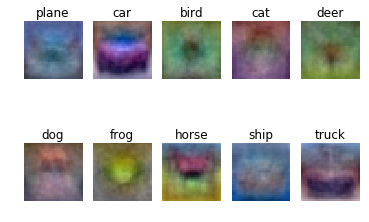

In [9]:
## Visualize the learned weights for each class
w = bestSoftmax.W[:-1,:] 
w = w.reshape(32, 32, 3, 10)

wMin, wMax = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i in xrange(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - wMin) / (wMax - wMin)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])